In [ ]:
import pandas as pd
import numpy as np
import torch, os, cv2, torchvision
import albumentations as A
from torchvision import transforms as T
from PIL import Image
from glob import glob
import gdown
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split

In [ ]:
def get_data(path, fl_name = "sport"):
    if os.path.isdir(path): print("Data has already downloaded") ;pass
    else:
        os.makedirs(path, exist_ok=True)
        url = 'https://drive.google.com/file/d/1CWFGa2WHTAe9eHhMcP2VWPOr4jMNkWYG/view?usp=sharing' if fl_name =="sport" else None

        data_id = url.split("/")[-2]
        prefix = "https://drive.google.com/uc?/export=download&id="

        gdown.download(prefix+data_id, path, quiet = False)
        folder = glob(f"{path}/*")[0]
        os.system(f"unzip {folder} -d {path}")
        os.remove(folder)


get_data(path="sport")

Downloading...
From: https://drive.google.com/uc?/export=download&id=1CWFGa2WHTAe9eHhMcP2VWPOr4jMNkWYG
To: /content/sport
100%|██████████| 866M/866M [00:06<00:00, 132MB/s]


In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as T

class CustomDataset(Dataset):
    def __init__(self, im_path, im_type, transformations=None):
        super().__init__()

        self.im_path = im_path
        self.im_type = im_type
        self.transformations = transformations
        self.class_name = {}

        ds = pd.read_csv(f"{im_path}/{im_type}.csv")

        if im_type == "train":
            self.im_id, self.im_class = ds['image_ID'], ds['label']
            self.uniq_class = [cls for cls in np.unique(self.im_class)]
            self.class_name = {keys: qiymat for qiymat, keys in enumerate(self.uniq_class)}
        else:
            self.im_id = ds["image_ID"]

    def __len__(self):
        return len(self.im_id)

    def read_im(self, idx):
        return Image.open(os.path.join(self.im_path, self.im_type, self.im_id[idx])).convert("RGB")

    def get_im_gt(self, idx, im_type):
        return (self.read_im(idx), self.class_name[self.im_class[idx]]) if im_type == "train" else (self.read_im(idx), None)

    def __getitem__(self, idx):
        im, gt = self.get_im_gt(idx, im_type=self.im_type)

        if self.transformations:
            im = self.transformations(im)

        return (im, gt) if self.im_type == "train" else im

# Modify the transformations as needed
transformer_train = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])])
transformer_test = T.Compose([
    T.Resize((224, 224), antialias=True),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])])

im_path = "sport/dataset/"
class_names
tr_ds = CustomDataset(im_path=im_path, im_type='train', transformations=transformer_train)
ts_ds = CustomDataset(im_path=im_path, im_type='test', transformations=transformer_test)


7

In [ ]:

# Divide to train dataset and validation dataset

tr_all = len(tr_ds)

val_len = int(tr_all*0.15)
tr_len = tr_all-val_len
val_data, tr_data = random_split(dataset=tr_ds, lengths=[val_len, tr_len])
print(f" Train: {len(tr_data)} ")
print(f" Validation: {len(val_data)}")


 Train: 6993 
 Validation: 1234


In [ ]:
# Dataloader
if __name__ == '__main__':
    tr_dl = DataLoader(dataset=tr_data, batch_size=8, shuffle=True, num_workers=0)
    ts_dl = DataLoader(dataset=ts_ds, batch_size=8, shuffle=False, num_workers=0)
    val_dl = DataLoader(dataset=val_data, batch_size=8, shuffle=False, num_workers=0)
    print(len(tr_dl))
    print(len(ts_dl))
    print(len(val_dl))

875
257
155


In [ ]:
!pip install timm


In [ ]:

import timm, torch

model = timm.create_model(model_name = "rexnet_150", pretrained = False, num_classes = len(class_name))
x  = torch.randn(10, 3, 224, 224)
model(x).shape
model.eval()

In [ ]:
epochs =10
device = "cuda" if torch.cuda.is_available() else "cpu"

loss_fc = torch.nn.CrossEntropyLoss()
optimazer = torch.optim.Adam(params = model.parameters(), lr=0.0003)

model.to(device)

In [ ]:


def train(model, tr_dl, val_dl, epochs, device, loss_fc, opt, save_prefix):
  tr_acc_sc_ = []
  val_acc_sc_, val_epoc_loss_ = [],[]
  tr_total =0
  best_loss = np.inf
  decrease, not_improve, early_stop_threshold= 1,0,5
  os.makedirs("best_model", exist_ok=True)

  print("Train is starting .....")

  for epoc in range(epochs):
      print(f"{epoc+1}- epoc is starting..")
      count=0
      tr_acc_sr, tr_total =0,0

      for idx, batch in enumerate(tr_dl):
          ims, gts = batch
          ims = ims.to(device)
          gts = gts.to(device)

          pred = model(ims)
          loss = loss_fc(pred, gts)

          tr_total+=ims.shape[0]
          pred_class = torch.argmax(pred, dim =1)
          count+=1
          tr_acc_sr+= (pred_class==gts).sum().item()

          optimazer.zero_grad()
          loss.backward()
          optimazer.step()

      model.eval()
      with torch.no_grad():
          val_acc_sc = 0
          val_total =0
          val_epoc_loss = 0

          for idx, batch in enumerate(val_dl):
              ims, gts = batch
              ims, gts = ims.to(device), gts.to(device)

              val_total+=ims.shape[0]

              pred = model(ims)


              pred_class = torch.argmax(pred, dim=1)
              val_acc_sc+=(pred_class==gts).sum().item()
              loss = loss_fc(pred, gts)
              val_epoc_loss+=loss.item()

              tr_ACC_SR = tr_acc_sr/tr_total
              VAL_acc_sc = val_acc_sc/val_total
              VAL_epoc_loss = val_epoc_loss/len(val_dl)


          print(f"{epoc+1} is finished..")
          print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
          print(f"{epoc+1} - epoc result:\n")
          print(f"{epoc+1}- epoc Train Accurancy score        -> {tr_ACC_SR:.2f}")
          print(f"{epoc+1}- epoc Validation Accurancy score   -> {VAL_acc_sc:.2f}")
          print(f"{epoc+1}- epoc Validation loss score        -> {VAL_epoc_loss:.2f}\n\n")


          tr_acc_sc_.append(tr_ACC_SR)
          val_acc_sc_.append(VAL_acc_sc)
          val_epoc_loss_.append(VAL_epoc_loss)


          print(type(best_loss))

          if val_epoc_loss < best_loss:

            print(f"Error is decreased from {best_loss:.3f} to {VAL_epoc_loss:.3f}")
            best_loss = VAL_epoc_loss
            decrease+=1
            if decrease%2==0:
                  print("The model is saved with the lowest error ...")
                  torch.save(model, f"best_model/{save_prefix}_best_model.pt")

          if VAL_epoc_loss > best_loss:
              not_improve+=1
              best_loss = VAL_epoc_loss

              print(f"  Error {not_improve} did not decrease during the epoch!")
              if not_improve == early_stop_threshold:
                  print(f"Stop training because of  Error did not decrease during {early_stop_threshold}  epoch ")
                  break

  return {"tr_acc_sc": tr_acc_sc_, "val_acc_sc": val_acc_sc_, "val_epoc_loss": val_epoc_loss_}



In [ ]:
result = train(model=model, tr_dl=tr_dl, val_dl=val_dl, epochs=10, device=device,
               loss_fc=loss_fc, opt=optimazer, save_prefix="sport")

Train is starting .....
1- epoc is starting..
1 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1 - epoc result:

1- epoc Train Accurancy score        -> 0.45
1- epoc Validation Accurancy score   -> 0.53
1- epoc Validation loss score        -> 1.27


<class 'float'>
Error is decreased from inf to 1.267
The model is saved with the lowest error ...
2- epoc is starting..
2 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2 - epoc result:

2- epoc Train Accurancy score        -> 0.63
2- epoc Validation Accurancy score   -> 0.62
2- epoc Validation loss score        -> 1.04


<class 'float'>
3- epoc is starting..
3 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
3 - epoc result:

3- epoc Train Accurancy score        -> 0.72
3- epoc Validation Accurancy score   -> 0.70
3- epoc Validation loss score        -> 0.81


<class 'float'>
4- epoc is starting..
4 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
4 - epoc result:

4- epoc Train Accurancy score        -> 0.80
4- epoc Validation Accurancy s

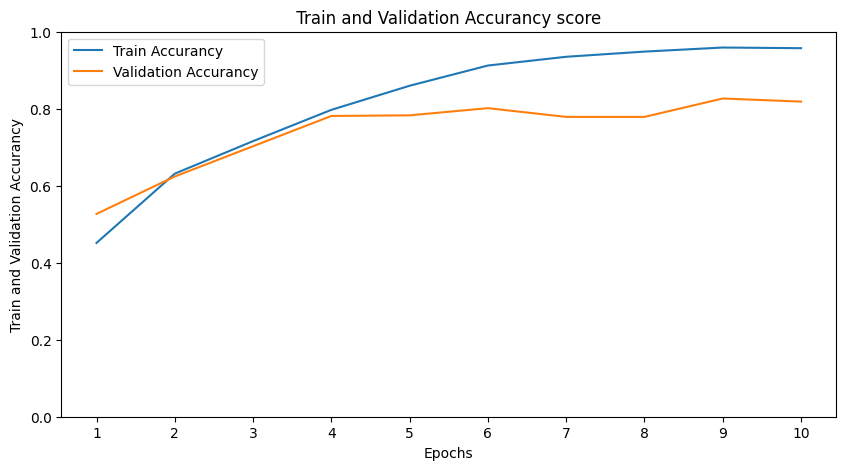

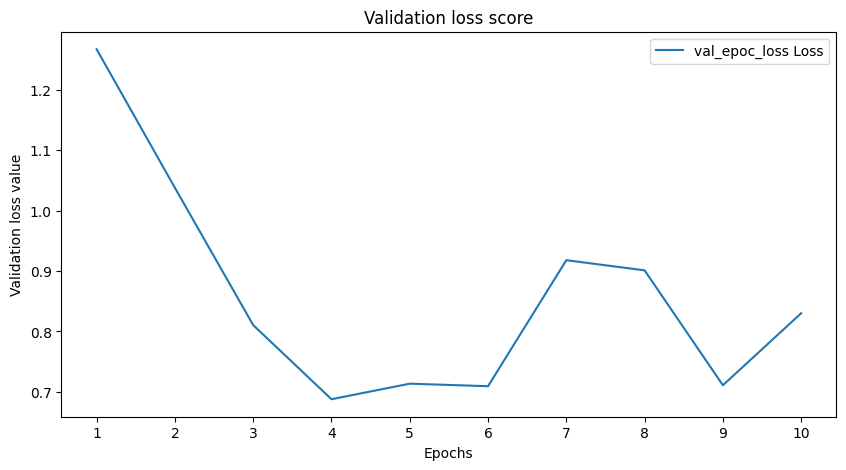

In [ ]:
import matplotlib.pyplot as plt

class Plot():
    def __init__(self, res):


        plt.figure(figsize =(10,5))
        plt.plot(res['tr_acc_sc'], label = 'Train Accurancy')
        plt.plot(res['val_acc_sc'], label = 'Validation Accurancy')
        plt.title(" Train and Validation Accurancy score ")
        plt.xlabel('Epochs')
        plt.xticks(np.arange(len(res['val_acc_sc'])), [i for i in range(1, len(res['val_acc_sc']) + 1)])
        plt.ylabel('Train and Validation Accurancy')
        plt.ylim(0, 1)
        plt.legend()
        plt.show()



        plt.figure(figsize = (10, 5))
        plt.plot(res['val_epoc_loss'], label = "val_epoc_loss Loss")
        # plt.plot(res['tr_loss'], label = "Train Loss")

        # plt.plot(res['val_loss'], label = "Validation Loss")
        plt.title("Validation loss score")
        plt.xlabel('Epochs')
        plt.xticks(np.arange(len(res['val_epoc_loss'])), [i for i in range(1, len(res['val_epoc_loss']) + 1)])

        plt.ylabel("Validation loss value")
        # plt.ylim(0, 1.5)
        plt.legend()
        plt.show()
Plot(result)




In [ ]:
def inference(dl, model, device):
  preds = []
  for idx, batch in enumerate(dl):
    if idx ==2: break
    im = batch

    pred = model(im.to(device))
    preds.append(pred)

model = torch.load("best_model/sport_best_model.pt")
inference( dl =ts_dl, model = model, device = device)

['Badminton', 'Cricket', 'Karate', 'Soccer', 'Swimming', 'Tennis', 'Wrestling']


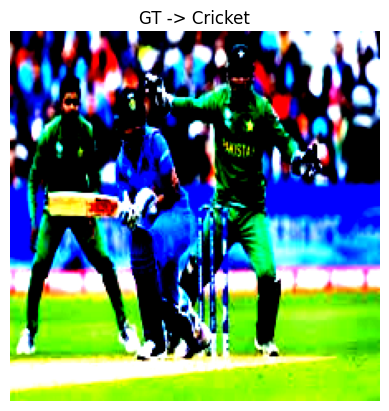

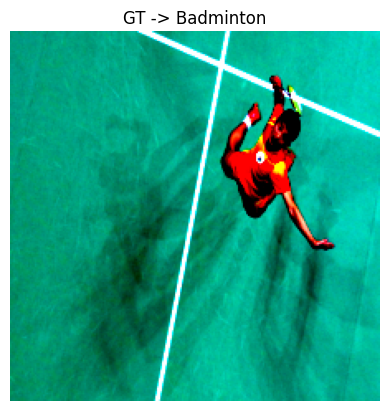

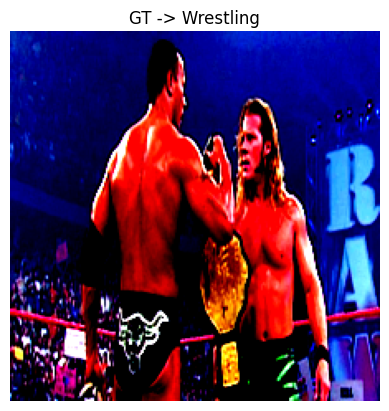

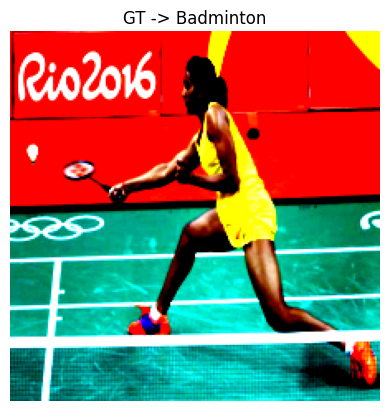

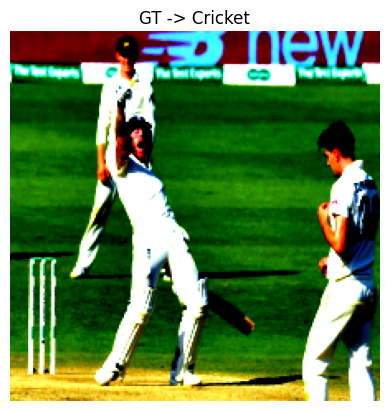

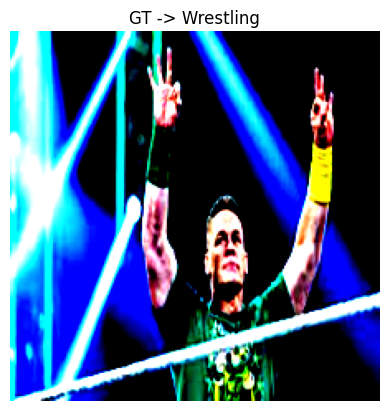

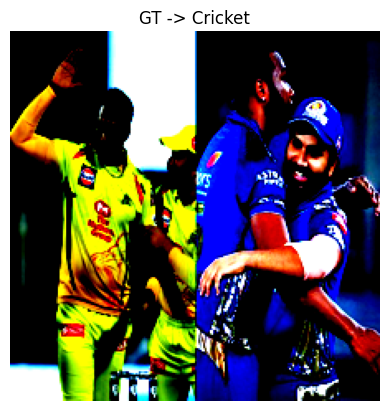

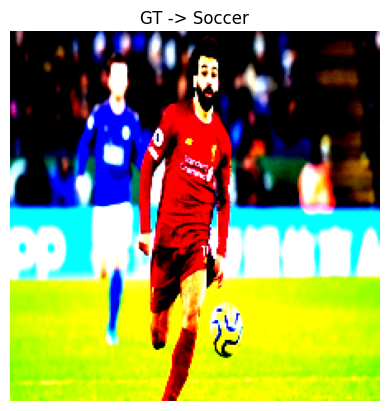

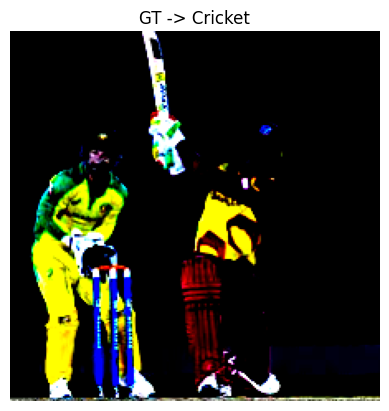

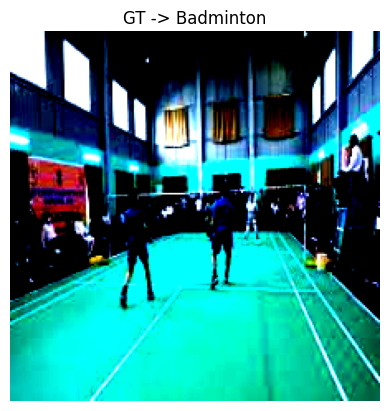

In [ ]:
import random
from matplotlib import pyplot as plt

class_name = list(tr_ds.class_name.keys())
print(class_name)

data_soni = 10
indekslar = [random.randint(0, len(ts_ds) - 1) for _ in range(data_soni)] # random integer ni qaytaradi

for idx, indeks in enumerate(indekslar):

    im, gt = tr_ds[indeks]
    im = np.transpose(im.numpy(), (1, 2, 0))

    plt.imshow(im); plt.axis("off")
    plt.title(f"GT -> {class_name[gt]}"); plt.show()